In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import mlflow
import mlflow.sklearn
import ast
from collections import Counter 
from sklearn.pipeline import Pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import pickle

c:\Users\Brani\OneDrive\Bureau\aida_project\project_05\.venv\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
# Charger les données déjà nettoyées
data = pd.read_csv("clean_questions.csv")
data.head()

,Id,Full_Text,Clean_Tags
0,11227809,process sorted array fast process unsorted arr...,"['java', 'cpu-architecture', 'branch-predictio..."
1,2003505,delete git branch locally remotely fail attemp...,"['version-control', 'git-branch', 'git-remote'..."
2,1642028,operator read hide feature dark corner cstl co...,"['code-formatting', 'c', 'standards-compliance..."
3,1125968,force git pull overwrite local file force over...,"['overwrite', 'git-fetch', 'version-control', ..."
4,79923,stack heap stack heap locate physically comput...,"['dynamic-memory-allocation', 'data-structures..."


In [3]:
def parse_tag_list(x):
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return parsed
        except:
            return []
    return x if isinstance(x, list) else []

data['Clean_Tags'] = data['Clean_Tags'].apply(parse_tag_list)

In [4]:
# Nettoyage complet + filtrage des 50 tags les plus fréquents
def clean_and_filter_tags(df, tag_column='Clean_Tags', top_n=50):
    # 1. Nettoyer les tags (liste de str en minuscule sans espaces)
    df[tag_column] = df[tag_column].apply(lambda tags:
        [str(tag).strip().lower() for tag in tags if isinstance(tag, str)] if isinstance(tags, list) else []
    )

    # 2. Compter les fréquences
    all_tags = [tag for tags in df[tag_column] for tag in tags]
    tag_counts = Counter(all_tags)
    
    # 3. Top N tags
    top_tags = set([tag for tag, _ in tag_counts.most_common(top_n)])
    
    # 4. Filtrer les tags
    df['Filtered_Tags'] = df[tag_column].apply(lambda tags: [tag for tag in tags if tag in top_tags])

    # 5. Supprimer les lignes sans tags
    df_filtered = df[df['Filtered_Tags'].map(len) > 0].copy()

    return df_filtered, pd.DataFrame(tag_counts.items(), columns=['Tag', 'Frequency']).sort_values(by='Frequency', ascending=False)

# ➤ Utilisation :
data_filtered, tag_freq_df = clean_and_filter_tags(data)


In [5]:
data_filtered

,Id,Full_Text,Clean_Tags,Filtered_Tags
0,11227809,process sorted array fast process unsorted arr...,"[java, cpu-architecture, branch-prediction, c+...","[java, c++, performance]"
1,2003505,delete git branch locally remotely fail attemp...,"[version-control, git-branch, git-remote, git,...",[git]
2,1642028,operator read hide feature dark corner cstl co...,"[code-formatting, c, standards-compliance, c++...","[c, c++]"
3,1125968,force git pull overwrite local file force over...,"[overwrite, git-fetch, version-control, git-pu...",[git]
5,178325,check element hide jquery toggle visibility el...,"[jquery, javascript, dom, visibility, display]","[jquery, javascript]"
...,...,...,...,...
9424,1001179,unix ssh script run command remote server like...,"[unix, shell, command, ssh, remote-server]",[shell]
9425,33473502,remove white space beginning end string get pr...,"[trim, string, whitespace, swift, ios]","[string, swift, ios]"
9426,3560950,good language parse extremely large excel file...,"[scripting, java, apache-poi, excel, excel-2007]",[java]
9427,12910697,connect device eclipse able resolve simple iss...,"[eclipse, android, galaxy, device, android-emu...","[eclipse, android]"


In [6]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)
X = vectorizer.fit_transform(data_filtered['Full_Text'])


# Encodage des tags
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data_filtered['Filtered_Tags'])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2025/08/12 14:59:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 15:00:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/12 15:00:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/12 15:00:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 15:00:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/08/12 15:00:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/12 15:00:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_


✅ LogisticRegression
F1 micro: 0.4241
F1 macro: 0.3185
Hamming Loss: 0.0282
Accuracy: 0.1628


2025/08/12 15:04:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 15:04:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/12 15:04:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/12 15:04:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 15:04:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/08/12 15:04:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/12 15:04:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_


✅ RandomForest
F1 micro: 0.4899
F1 macro: 0.3073
Hamming Loss: 0.0263
Accuracy: 0.2076


2025/08/12 15:04:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 15:04:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/12 15:04:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/12 15:04:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 15:04:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/08/12 15:04:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/12 15:04:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_


✅ SVC
F1 micro: 0.6192
F1 macro: 0.5608
Hamming Loss: 0.0231
Accuracy: 0.2924

📊 Résumé des performances :


,Model,F1 Micro,F1 Macro,Hamming Loss,Accuracy
2,SVC,0.619228,0.560777,0.023073,0.292431
1,RandomForest,0.489878,0.307282,0.026296,0.207569
0,LogisticRegression,0.424129,0.318491,0.028245,0.162844


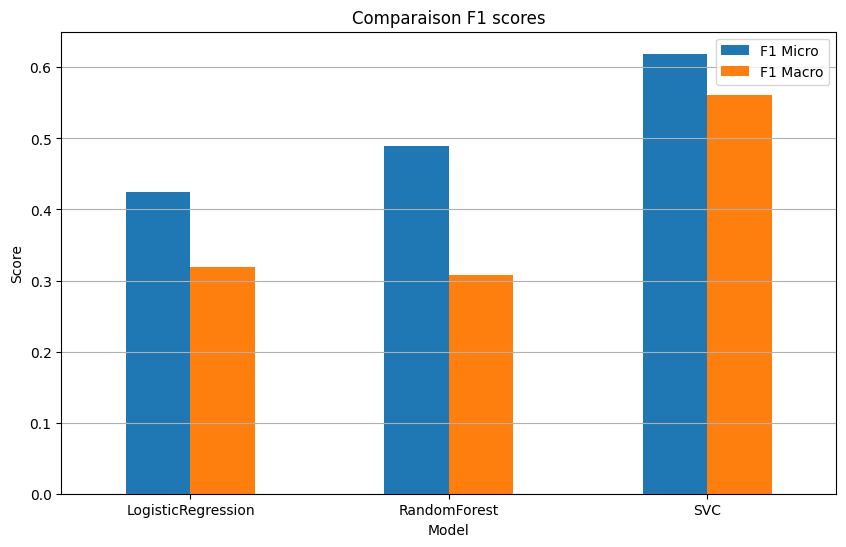

In [ ]:
# Définir les modèles
models = {
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "SVC": OneVsRestClassifier(LinearSVC())
}

# Liste pour stocker les résultats
results = []

# Entraînement + évaluation + tracking
for model_name, model in models.items():
    with mlflow.start_run(run_name=f"TFIDF_{model_name}"):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcul de plusieurs métriques
        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        hamming = hamming_loss(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        # Log MLFlow
        mlflow.log_param("model", model_name)
        mlflow.log_param("vectorizer", "tfidf")
        mlflow.log_metrics({
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "hamming_loss": hamming,
            "accuracy": acc
        })
        mlflow.sklearn.log_model(model, f"model_{model_name}")
        mlflow.sklearn.log_model(vectorizer, "tfidf_vectorizer")
        
        # Sauvegarde et log de l'objet MultiLabelBinarizer
        with open("mlb.pkl", "wb") as f:
            pickle.dump(mlb, f)
        mlflow.log_artifact("mlb.pkl")

        # Affichage console
        print(f"\n✅ {model_name}")
        print(f"F1 micro: {f1_micro:.4f}")
        print(f"F1 macro: {f1_macro:.4f}")
        print(f"Hamming Loss: {hamming:.4f}")
        print(f"Accuracy: {acc:.4f}")

        # Stocker les résultats
        results.append({
            "Model": model_name,
            "F1 Micro": f1_micro,
            "F1 Macro": f1_macro,
            "Hamming Loss": hamming,
            "Accuracy": acc
        })

# Résultats en DataFrame
results_df = pd.DataFrame(results)

# Affichage tabulaire
print("\n📊 Résumé des performances :")
display(results_df.sort_values("F1 Micro", ascending=False))

# Graphique des F1-scores
results_df.plot(x="Model", y=["F1 Micro", "F1 Macro"], kind="bar", figsize=(10, 6), title="Comparaison F1 scores")
plt.ylabel("Score")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

## 🔍 Interprétation des résultats des modèles supervisés (TF-IDF + MultiLabel)

| Modèle               | Interprétation |
|----------------------|----------------|
| ✅ **SVC**            | C'est le modèle le plus performant ici. Il obtient le **meilleur score F1 (micro et macro)**, ce qui indique qu’il parvient bien à capturer les bons tags même sur des classes déséquilibrées. Le **Hamming Loss** est le plus bas, donc il fait peu d’erreurs par tag. Enfin, sa **précision globale (accuracy)** est la plus élevée, ce qui confirme qu’il prédit assez bien l’ensemble des tags associés à chaque question. |
| **Random Forest**     | Moins performant que SVC. Il montre un bon F1 micro mais un F1 macro beaucoup plus faible, ce qui signifie qu’il réussit sur les tags fréquents mais a du mal avec les moins représentés. Le Hamming Loss est un peu plus élevé, indiquant plus d’erreurs tag par tag. |
| **Logistic Regression** | Le modèle le plus simple ici. Il obtient les **scores les plus bas**, notamment en F1 micro et accuracy. Cela montre qu’il a du mal à bien apprendre à partir des représentations TF-IDF pour des problèmes multi-label complexes. |

### 🧠 Conclusion
- **SVC** est le meilleur choix dans cette configuration TF-IDF.
- Il faudra vérifier si les résultats sont cohérents sur d'autres représentations textuelles (Word2Vec, BERT…).
- L'utilisation de plusieurs métriques (F1 micro/macro, Hamming Loss, Accuracy) permet une **évaluation plus complète** de la qualité des modèles multi-label.


### Doc2Vec

In [8]:
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(data_filtered['Full_Text'])]
doc2vec_model = Doc2Vec(documents, vector_size=200, window=5, min_count=5, workers=4, epochs=150)

X_doc2vec = [doc2vec_model.infer_vector(text.split()) for text in data_filtered['Full_Text']]
X_train, X_test, y_train, y_test = train_test_split(X_doc2vec, y, test_size=0.2, random_state=42)

In [9]:
X_doc2vec = np.array(X_doc2vec)
print("Shape of X_doc2vec:", X_doc2vec.shape)
print("Shape of y:", y.shape)

Shape of X_doc2vec: (8717, 200)
Shape of y: (8717, 50)


In [10]:
models = {
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100)),
    "SVC": OneVsRestClassifier(LinearSVC())
}

In [11]:
results_doc2vec = []

for model_name, model in models.items():
    with mlflow.start_run(run_name=f"Doc2Vec_{model_name}"):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        hamming = hamming_loss(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        # MLflow logs
        mlflow.log_param("model", model_name)
        mlflow.log_param("embedding", "Doc2Vec")
        mlflow.log_metric("f1_micro", f1_micro)
        mlflow.log_metric("f1_macro", f1_macro)
        mlflow.log_metric("hamming_loss", hamming)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, f"model_{model_name}_doc2vec")

        # Store results
        results_doc2vec.append({
            "Model": model_name,
            "F1 Micro": f1_micro,
            "F1 Macro": f1_macro,
            "Hamming Loss": hamming,
            "Accuracy": accuracy
        })

# Afficher un tableau récapitulatif
results_df = pd.DataFrame(results_doc2vec)

display(results_df)

2025/08/10 16:48:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 16:48:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/10 16:48:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/10 16:57:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 16:58:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/10 16:58:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/10 16:58:18 WARNING mlflow.model

,Model,F1 Micro,F1 Macro,Hamming Loss,Accuracy
0,LogisticRegression,0.518831,0.445246,0.031353,0.182913
1,RandomForest,0.004313,0.001352,0.037064,0.001720
2,SVC,0.509556,0.418615,0.031193,0.181766


| Méthode     | Ce qu’elle fait                       | Ce qu’elle comprend               |
| ----------- | ------------------------------------- | --------------------------------- |
| **TF-IDF**  | Compte les mots                       | Pas de sens, juste les fréquences |
| **Doc2Vec** | Apprend des vecteurs avec le contexte | Comprend le **sens du texte**     |


### Word2Vec

In [12]:
# Entraîner Word2Vec sur corpus
tokenized_texts = [text.split() for text in data_filtered['Full_Text']]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=5, workers=4)

# Fonction pour faire la moyenne des vecteurs de mots
def get_w2v_vector(text):
    tokens = text.split()
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

X_w2v = np.array([get_w2v_vector(text) for text in data_filtered['Full_Text']])


In [13]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_w2v , y, test_size=0.2, random_state=42)

# Entraînement + évaluation + tracking
for model_name, model in models.items():
    with mlflow.start_run(run_name=f"TFIDF_{model_name}"):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcul de plusieurs métriques
        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        hamming = hamming_loss(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        
        # entrée pour la signature
        input_example = np.array([X_train[0]])

        # Log MLFlow
        mlflow.log_param("model", model_name)
        mlflow.log_param("vectorizer", "tfidf")
        mlflow.log_metrics({
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "hamming_loss": hamming,
            "accuracy": acc
        })
        mlflow.sklearn.log_model(model, f"model_{model_name}_doc2vec", input_example=input_example)


        # Stocker les résultats
        results.append({
            "Model": model_name,
            "F1 Micro": f1_micro,
            "F1 Macro": f1_macro,
            "Hamming Loss": hamming,
            "Accuracy": acc
        })

# Résultats en DataFrame
results_df_w2v = pd.DataFrame(results)

# Affichage tabulaire
print("\n📊 Résumé des performances :")
display(results_df_w2v.sort_values("F1 Micro", ascending=False))

2025/08/10 16:58:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 16:58:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
c:\Users\Brani\OneDrive\Bureau\aida_project\project_05\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/08/10 17:03:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 17:03:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/10 17:03:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 17:03:36 WARNING mlflow.utils.


📊 Résumé des performances :


,Model,F1 Micro,F1 Macro,Hamming Loss,Accuracy
2,SVC,0.619228,0.560777,0.023073,0.292431
1,RandomForest,0.489878,0.307282,0.026296,0.207569
0,LogisticRegression,0.424129,0.318491,0.028245,0.162844
5,SVC,0.422941,0.291574,0.029885,0.143922
3,LogisticRegression,0.405246,0.288489,0.031204,0.122133
4,RandomForest,0.326501,0.212117,0.031651,0.099197


### Use_model

In [14]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_use = use_model(data_filtered['Full_Text'].tolist()).numpy()

In [15]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_use, y, test_size=0.2, random_state=42)

# Liste pour stocker les résultats
results_use = []

# Entraînement + évaluation + suivi MLflow
for model_name, model in models.items():
    with mlflow.start_run(run_name=f"USE_{model_name}"):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        hamming = hamming_loss(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        # entrée pour la signature
        input_example = np.array([X_train[0]])

        # Logs MLflow
        mlflow.log_param("model", model_name)
        mlflow.log_param("embedding", "USE")
        mlflow.log_metric("f1_micro", f1_micro)
        mlflow.log_metric("f1_macro", f1_macro)
        mlflow.log_metric("hamming_loss", hamming)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, f"model_{model_name}_use", input_example=input_example)

        # Stocker les résultats
        results_use.append({
            "Model": model_name,
            "F1 Micro": f1_micro,
            "F1 Macro": f1_macro,
            "Hamming Loss": hamming,
            "Accuracy": accuracy
        })

# Affichage des résultats
results_df_use = pd.DataFrame(results_use)
print("\n📊 Résumé des performances (USE) :")
display(results_df_use.sort_values("F1 Micro", ascending=False))

2025/08/10 17:04:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 17:04:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/10 17:15:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 17:16:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/10 17:16:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 17:16:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



📊 Résumé des performances (USE) :


,Model,F1 Micro,F1 Macro,Hamming Loss,Accuracy
2,SVC,0.661791,0.579905,0.021743,0.326261
0,LogisticRegression,0.592578,0.458229,0.023544,0.282110
1,RandomForest,0.474515,0.299450,0.026720,0.198968


**Bert **model****

In [16]:
from transformers import BertTokenizer, BertModel
import torch

# Charger le tokenizer et le modèle BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Fonction pour encoder un texte avec BERT (moyenne des embeddings des tokens)
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Moyenne des embeddings du dernier layer
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Appliquer à tout le corpus
X_bert = np.array([get_bert_embedding(text) for text in data_filtered['Full_Text']])

In [17]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

results_bert = []

for model_name, model in models.items():
    with mlflow.start_run(run_name=f"BERT_{model_name}"):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        hamming = hamming_loss(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        input_example = np.array([X_train[0]])

        mlflow.log_param("model", model_name)
        mlflow.log_param("embedding", "BERT")
        mlflow.log_metric("f1_micro", f1_micro)
        mlflow.log_metric("f1_macro", f1_macro)
        mlflow.log_metric("hamming_loss", hamming)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, f"model_{model_name}_bert", input_example=input_example)

        results_bert.append({
            "Model": model_name,
            "F1 Micro": f1_micro,
            "F1 Macro": f1_macro,
            "Hamming Loss": hamming,
            "Accuracy": accuracy
        })

results_df_bert = pd.DataFrame(results_bert)
print("\n📊 Résumé des performances (BERT) :")
display(results_df_bert.sort_values("F1 Micro", ascending=False))

2025/08/10 17:40:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 17:40:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/10 18:02:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 18:03:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/10 18:04:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 18:04:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



📊 Résumé des performances (BERT) :


,Model,F1 Micro,F1 Macro,Hamming Loss,Accuracy
2,SVC,0.511313,0.477013,0.031456,0.186927
0,LogisticRegression,0.485603,0.439656,0.028888,0.180046
1,RandomForest,0.040927,0.023228,0.036548,0.012041
